In [1]:
import numpy as np
import pandas as pd
import pylandstats as pls
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm, colors
import rasterio
import glob

------

# Load Data

In [2]:
# upload fire information, burn severity geotiffs
# create pls.Landscape objects from geotiffs
# specify burn severity class names

findex = pd.read_csv('../doc/fire_info.csv')
fpaths = glob.glob('../fires/*.tif')
fpaths.sort()
fnames = []
for i in range(0,len(findex.index)):
    fnames.append('{}'.format(findex.iloc[i,0]))
fires = []
for i in range(0,len(fpaths)):
    fires.append(pls.Landscape(fpaths[i],nodata=0))
multifire = pls.SpatioTemporalAnalysis(fires,dates=fnames)
class_names = ['unburned',
              'low severity',
              'moderate severity',
              'high severity',
              'increased greenness',
              'cloud mask']

-----

# Visualize Data

In [3]:
# dict of fire-specific colormaps

fcmap = {}
for i in range(0,len(findex.index)):
    d = rasterio.open(glob.glob('../fires/{}*.tif'.format(findex.iloc[i,0]))[0],nodata=0)
    d = d.read()
    n = np.size(np.unique(d))  
    m = colors.ListedColormap([(0,0,0,.7),    #nodata
                               (.25,.5,0,1),   #unburned
                               (.95,.92,0,1), #low
                               (.89,.46,0,1), #moderate
                               (.87,0,0,1),   #high
                               (.4,.8,0,1),   #increased green
                               (.5,.9,1,1)], #cloud mask
                               N=n)
    fcmap[findex.iloc[i,0]] = m

In [4]:
# function for plotting individual fire by findex.index number

def pltfire(n):
    """plots fire specified by findex index number"""
    fires[n].plot_landscape(legend=True,cmap=fcmap[findex.iloc[n,0]],figsize=[10,10])
    #plt.legend(loc='center right',frameon=False,bbox_to_anchor=(1.7,0.5),ncol=1,labels=class_types)
    plt.legend(loc='lower right',labels=class_names)
    plt.title('{}, {}'.format(findex.iloc[n,2],findex.iloc[n,1]),fontsize=16)
    return plt.show()

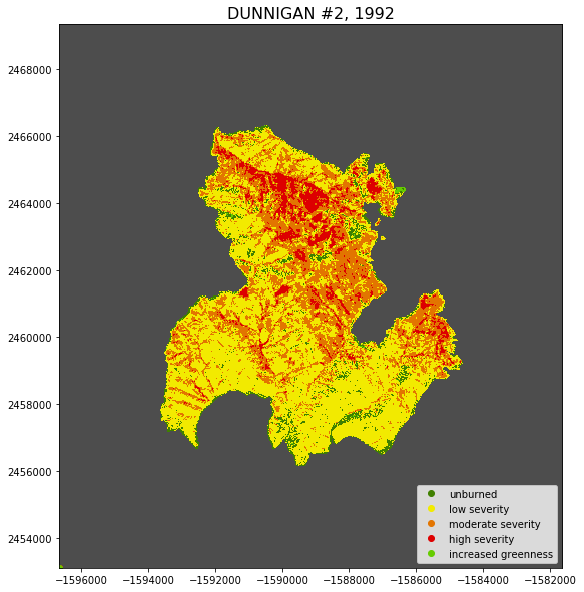

In [5]:
# plot fire

pltfire(21)

-----------

# Class Metrics

- Landscape.proportion_of_landscape(*class_val, percent=True*)
- Landscape.number_of_patches(*class_val=None*)
- Landscape.patch_density(*class_val=None, percent=True, hectares=True*)
- Landscape.largest_patch_index(*class_val=None, percent=True*)
- Landscape.landscape_shape_index(*class_val=None*)

In [6]:
# list of class metrics
# dict of kwargs

cmetrics = ['proportion_of_landscape',
            'number_of_patches',
            'patch_density',
            'largest_patch_index',
            'landscape_shape_index']
ckwargs = {'proportion_of_landscape':{'percent':False},
           'patch_density':{'percent':False},
           'largest_patch_index':{'percent':False}}

In [ ]:
# compute class metrics
# reformat dataframe

fclass = multifire.compute_class_metrics_df(metrics=cmetrics,metrics_kws=ckwargs)
fclass.rename_axis(index=('burn_severity_class','fire_id'),inplace=True)
fx_merge = findex.set_index('Fire_ID')
fid = fclass.index.get_level_values('fire_id')
fclass['year'] = fx_merge.loc[fid].Year.values
fclass['fire_name'] = fx_merge.loc[fid].Fire_Name.values
fclass = fclass.swaplevel(0,1).groupby(['fire_id','fire_name','year','burn_severity_class']).first()
fclass.sort_values(by=['year','fire_name','burn_severity_class'],inplace=True)
classes = list(range(1,7))
class_dict = dict(zip(classes,class_names))
fclass.rename(index=class_dict,inplace=True)
fclass

------

# Landscape Metrics

- Landscape.total_area(*class_val=None,hectares=True*)
- Landscape.patch_density(*class_val=None, percent=True, hectares=True*)
- Landscape.largest_patch_index(*class_val=None, percent=True*)
- Landscape.landscape_shape_index(*class_val=None*)
- Landscape.contagion(*percent=True*)
- Landscape.shannon_diversity_index()

In [ ]:
# list of class metrics
# dict of kwargs

lmetrics = ['total_area',
            'patch_density',
            'largest_patch_index',
            'landscape_shape_index',
            'contagion',
            'shannon_diversity_index']
lkwargs = {'patch_density':{'percent':False},
           'largest_patch_index':{'percent':False},
           'contagion':{'percent':False}}

In [ ]:
# compute class metrics
# reformat dataframe

fland = multifire.compute_landscape_metrics_df(metrics=lmetrics,metrics_kws=lkwargs)
fland.rename_axis(index=('fire_id'),inplace=True)
fland['year'] = findex['Year'].values
fland['fire_name'] = findex['Fire_Name'].values
fland = fland.groupby(['fire_id','fire_name','year']).first()
fland.sort_values(by=['year','fire_name'],inplace=True)
fland.head(5)

------

# Comments

- *Successfully formatted dataframe for class metrics*
- *Successfully added additional class metrics, including kwargs*
- *Successfully formatted dataframe for landscape metrics*
- *Successfully added additional landscape metrics, including kwargs*

**Next up:**
0. figure out how to easily specify the fire to be plotted
1. add map of every fire
2. learn how to access the data by fire, year, class, etc.
3. statistical analyses and plotting
4. learn more about edge metrics (applicability?)
5. learn more about distribution-statistics metrics (applicability?)